In [1]:
library(coda)
library(rjags)
set.seed(123)
library(ggplot2)

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



**Gaia Volpi, ID = 2107759**
## Esercizio 1

Given the following un-normalized posterior distribution:

$g(\theta | x) \propto \frac{1}{2} exp - \frac{(\theta + 3)^2}{2} + \frac{1}{2} exp - \frac{(\theta - 3)^2}{2} $

1) Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm.
- Use a Norm (0, 1) as random-walk candidate density.

In [10]:
posterior = function(theta) {
  return(0.5 * exp(-(theta + 3)^2 / 2) + 0.5 * exp(-(theta - 3)^2 / 2))
}

MC = function(n.samp, theta.init, sigma) {
    theta.cur = theta.init
    func.cur = posterior(theta.cur)
    func.samp = matrix(data = NA, nrow = n.samp, ncol = 2)
    
    for (i in 1:n.samp) {
        theta.prop = rnorm(1, theta.cur, sigma)
        func.prop = posterior(theta.prop)
        
        rho = func.prop/func.cur
        if (rho>=1 || rho>=runif(1)) { # sbagliato 
            theta.cur = theta.prop
            func.cur = func.prop
        }
        func.samp[i, 1] = func.cur
        func.samp[i, 2] = theta.cur
  }
  return(func.samp)
}

2) Plot the sampled distribution:

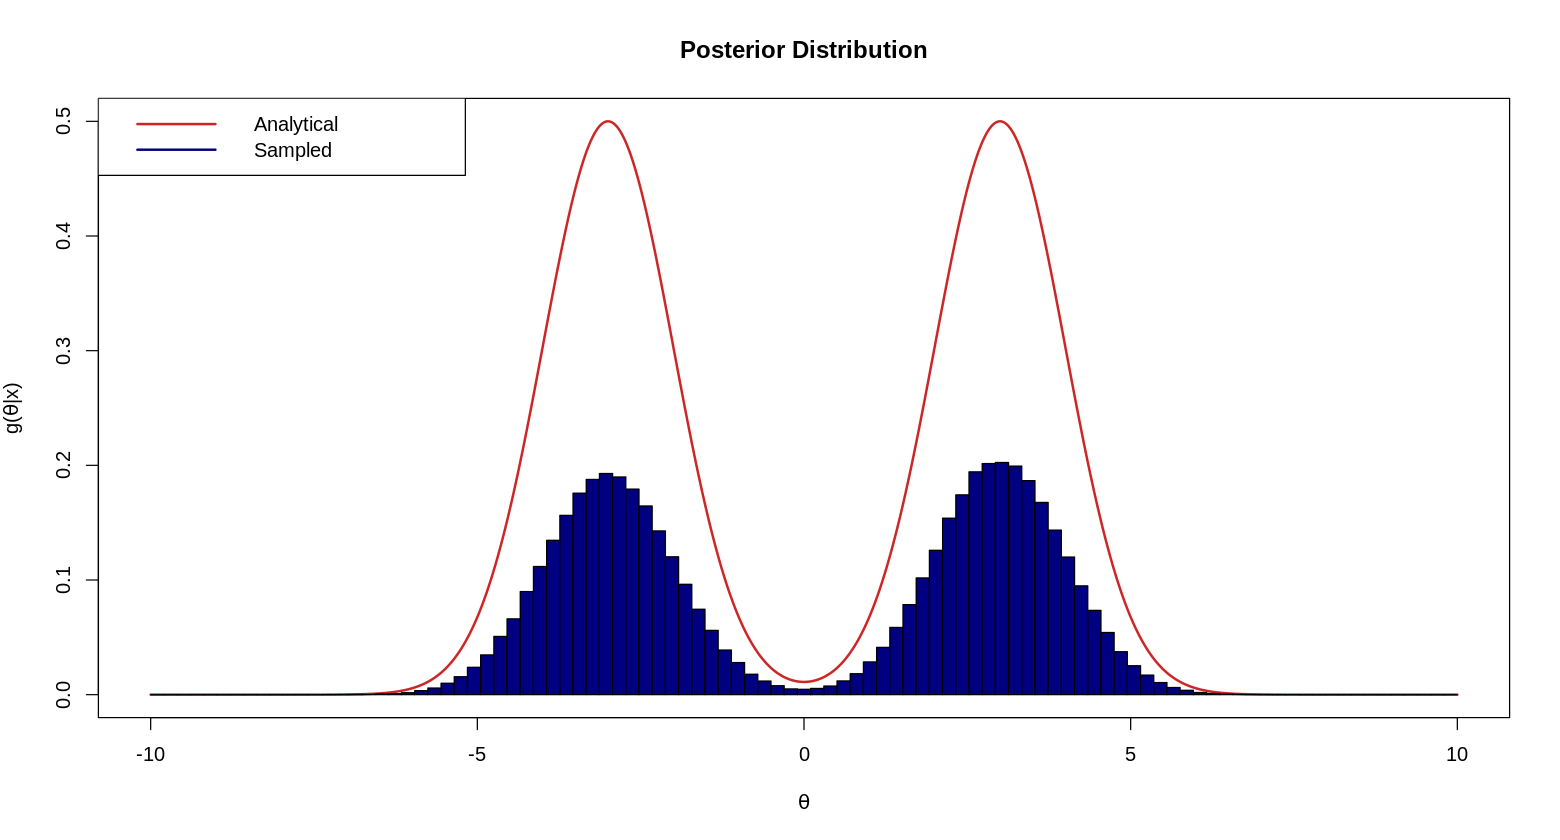

In [14]:
n.samp = 10^6  
theta.init = 0  
sigma = 1

set.seed(123)  
chain = MC(n.samp, theta.init, sigma)

x = seq(-10, 10, length.out = 10^4)
y = posterior(x)

plot(x, y, type='l', lwd=2, col='firebrick3', xlab=expression(theta), ylab=expression(paste('g(',theta, '|x)', sep = '')),
     main = "Posterior Distribution")

hist(chain[,2], breaks = seq(from = min(x), to = max(x), length.out = 100), freq = FALSE, col = 'navy', main = "Sampled Distribution", add = TRUE)

legend("topleft", legend = c('Analytical', 'Sampled'), col=c('firebrick3', 'navy'), lwd = 2)

3) Analyze the chain with the CODA package and plot the chain autocorrelation:


Iterations = 1:1e+06
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+06 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      0.095846       3.161696       0.003162       0.055349 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-4.635 -2.956  1.123  3.037  4.667 



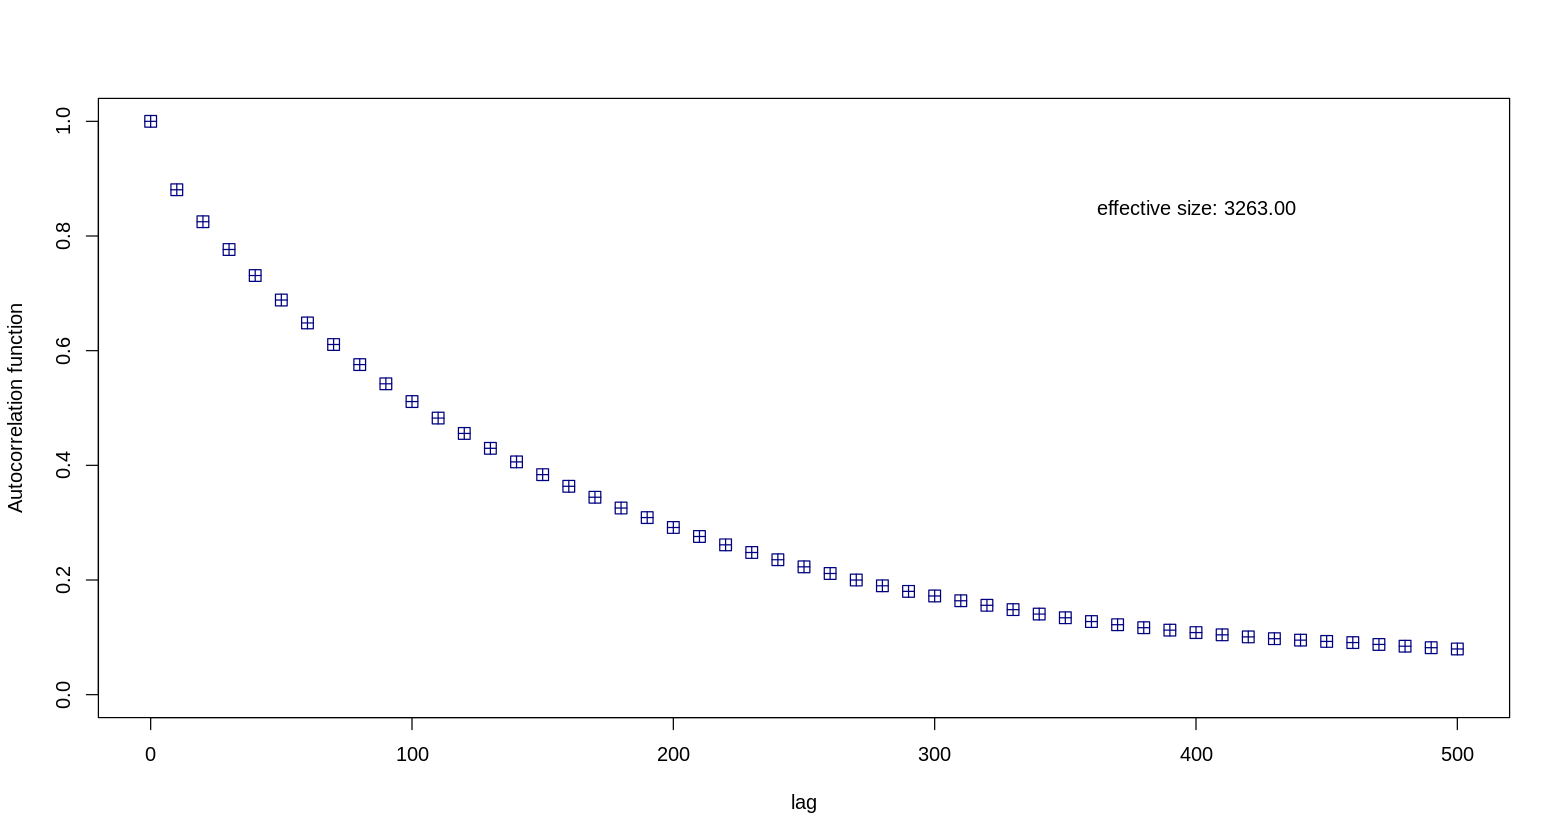

In [15]:
c.chain = as.mcmc(chain[,2]) 
my.lags = seq(0,500,10)
y = autocorr(c.chain, lags=my.lags)

print(summary(c.chain))
      
plot(my.lags, y, ylim=c(0,1), pch=12, col='navy', xlab='lag', ylab='Autocorrelation function', cex=1.3)
text(400,0.85, sprintf("effective size: %.2f", effectiveSize(c.chain)))

4) Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?

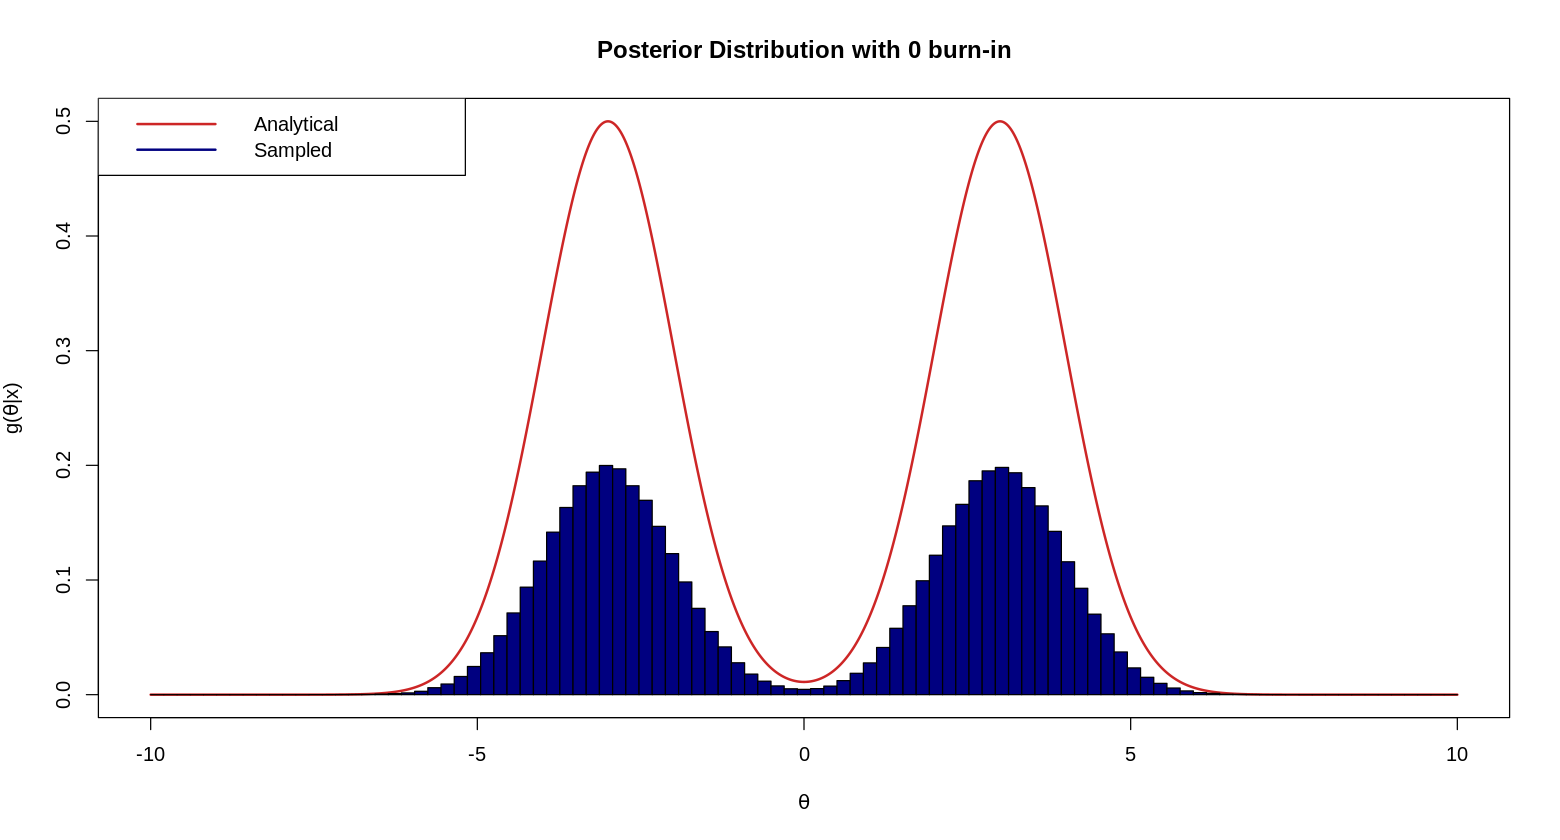

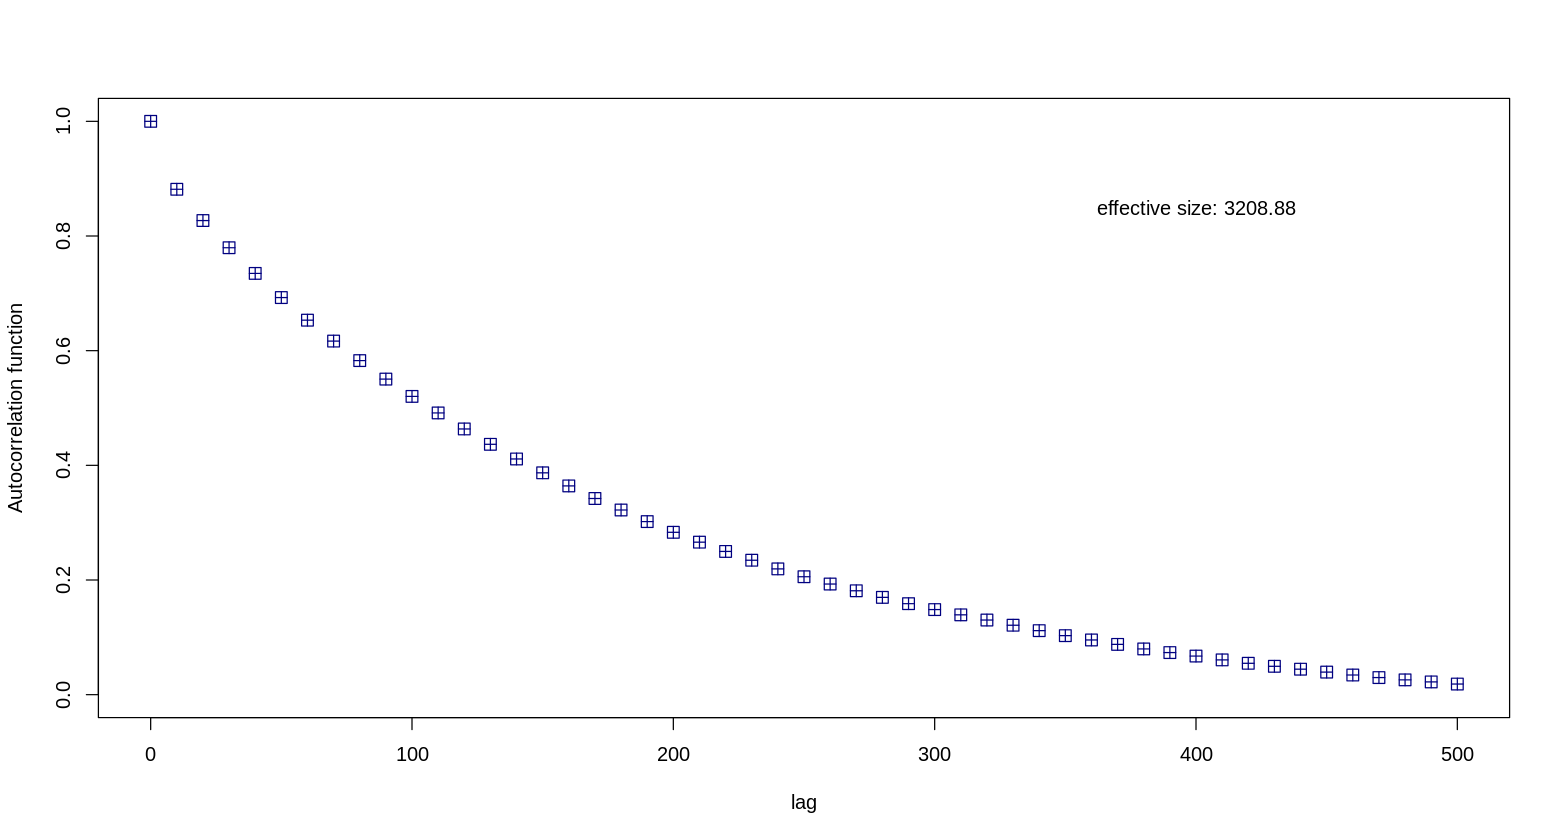

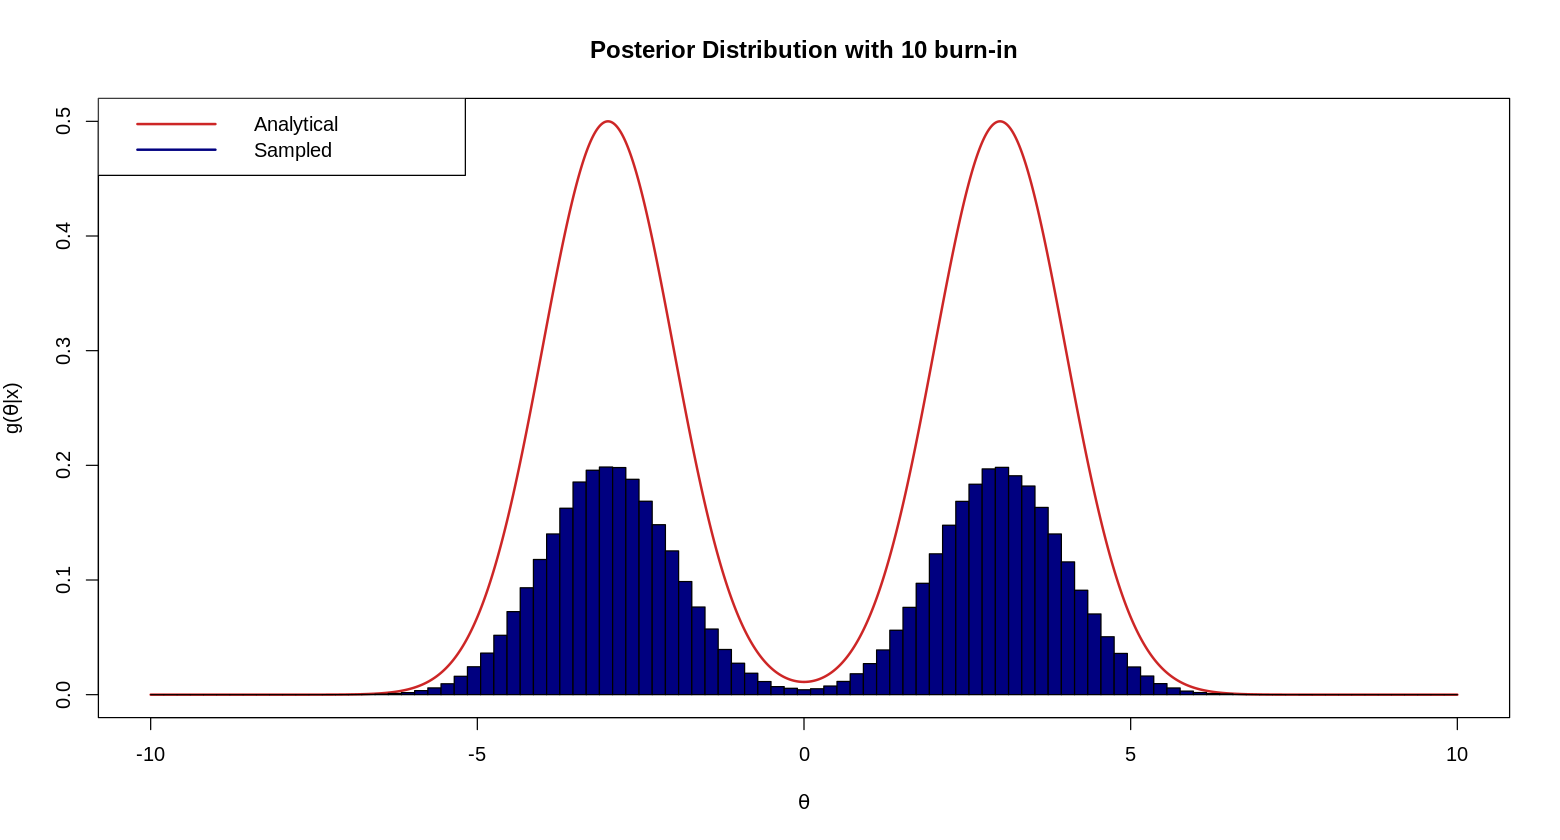

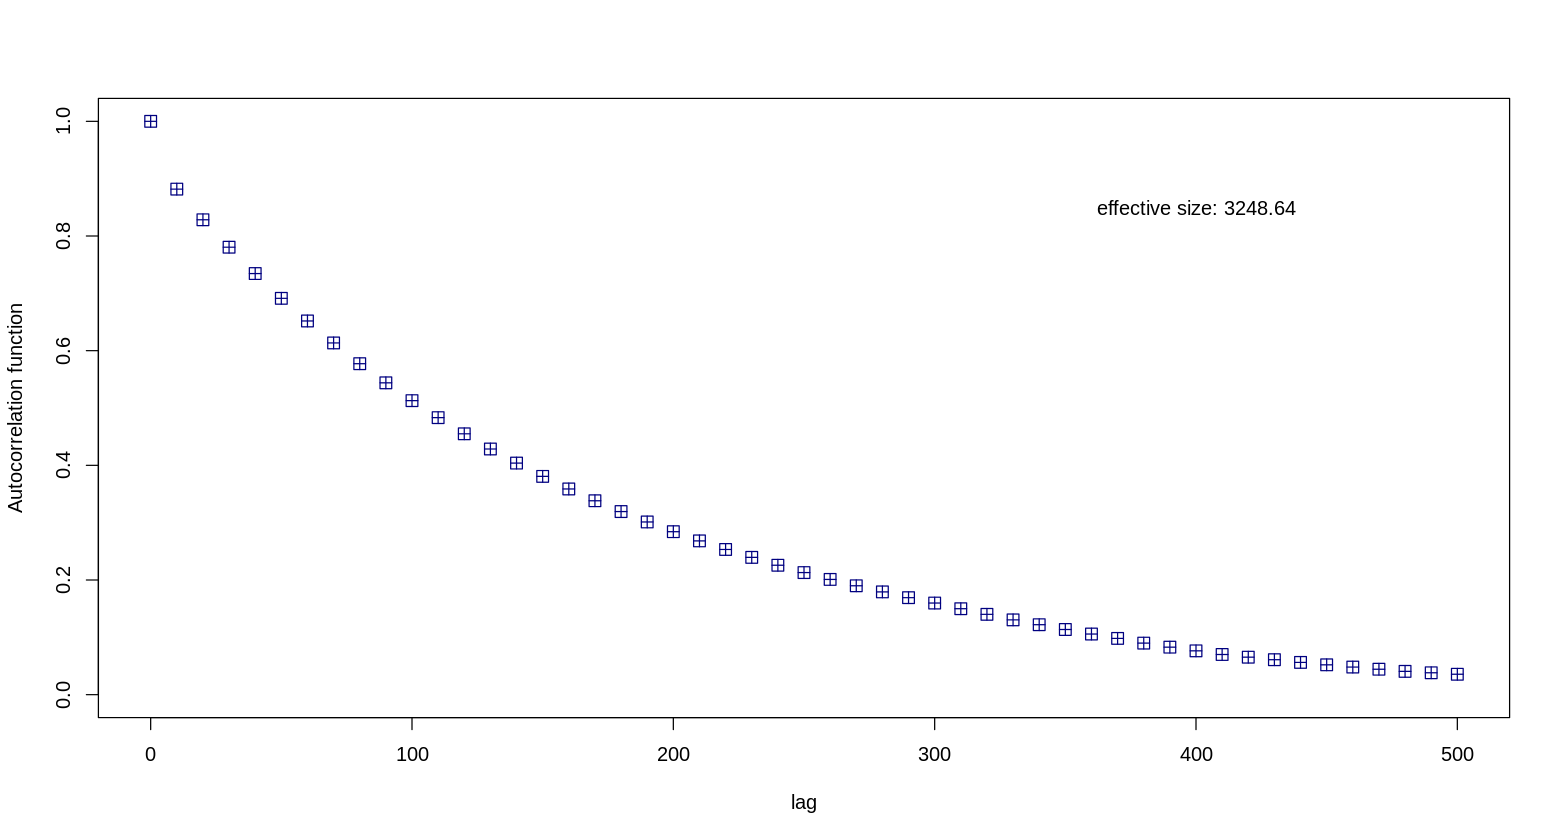

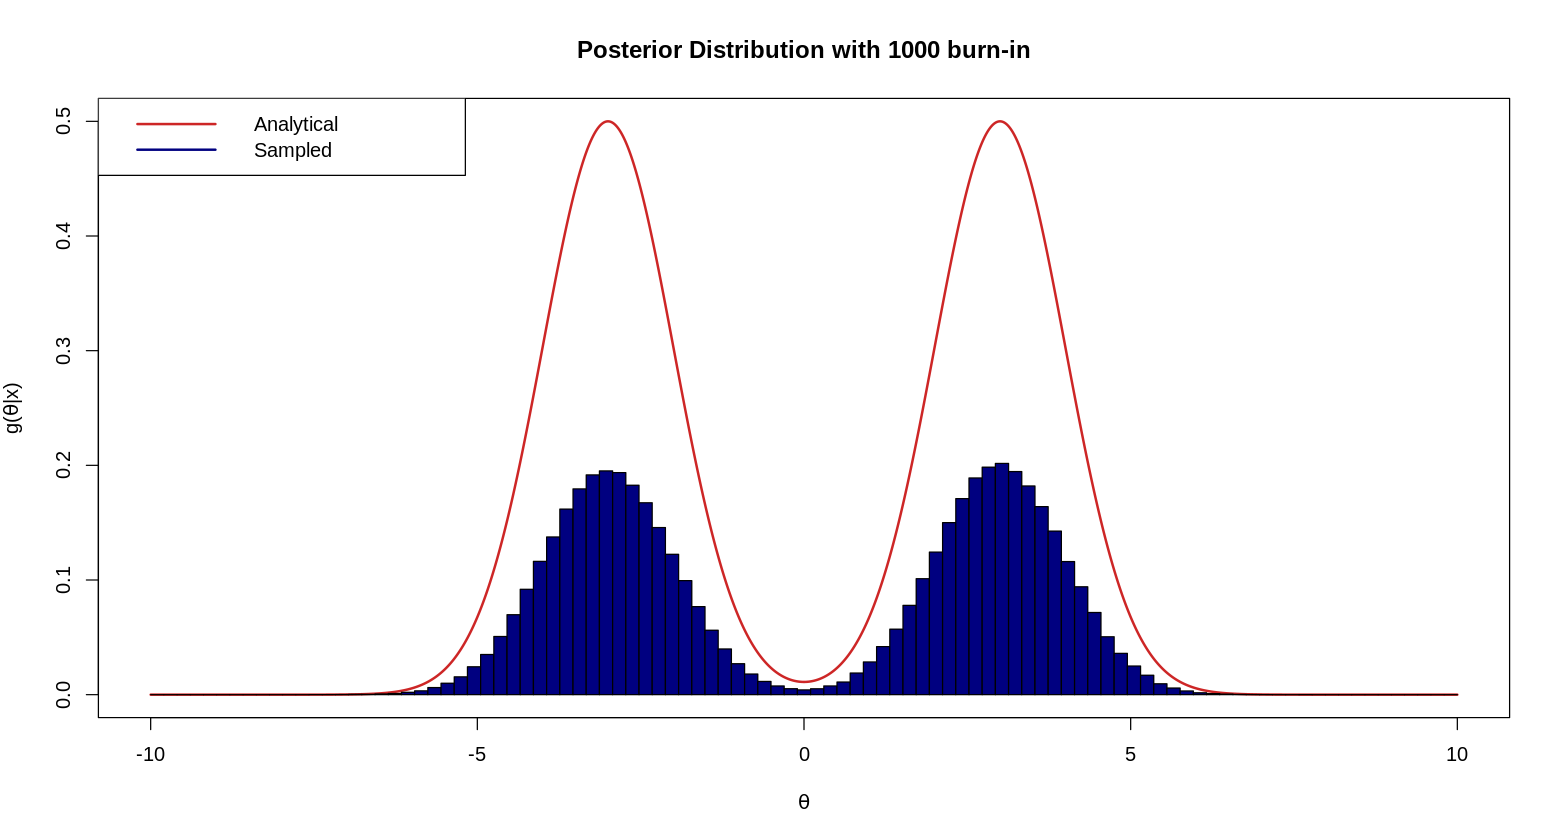

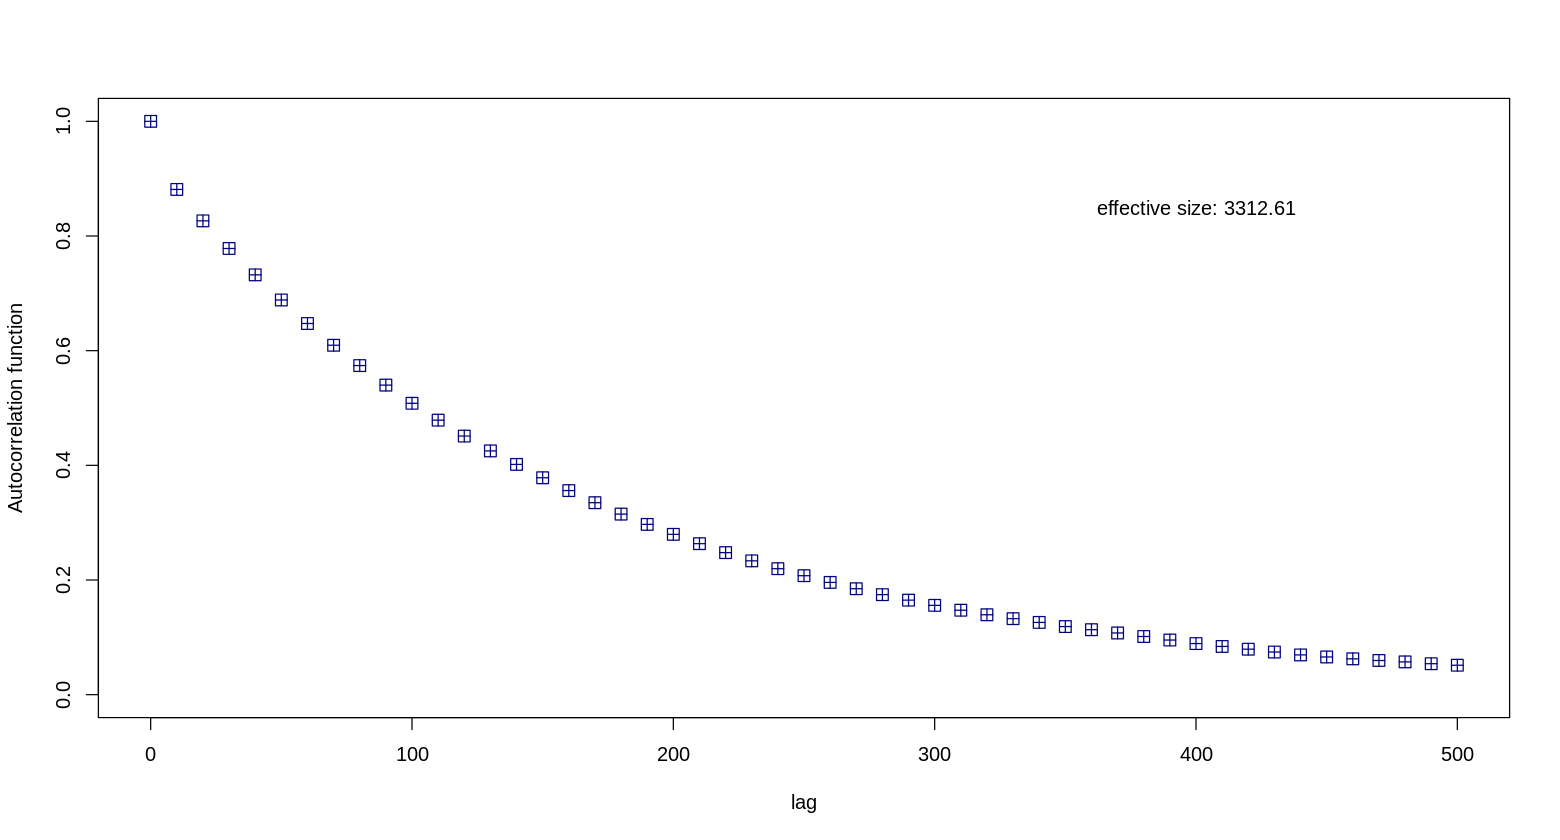

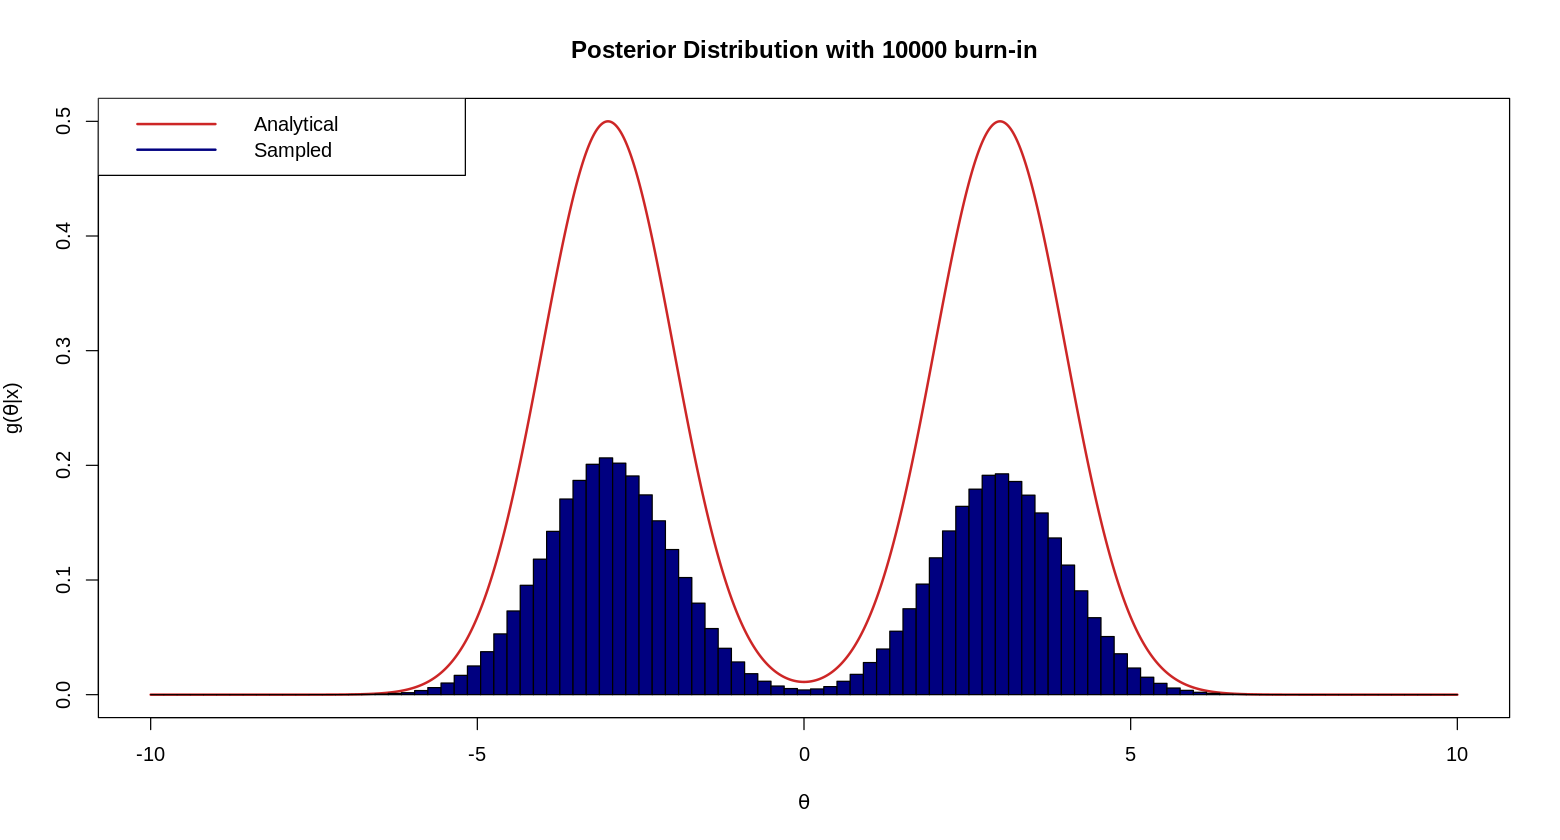

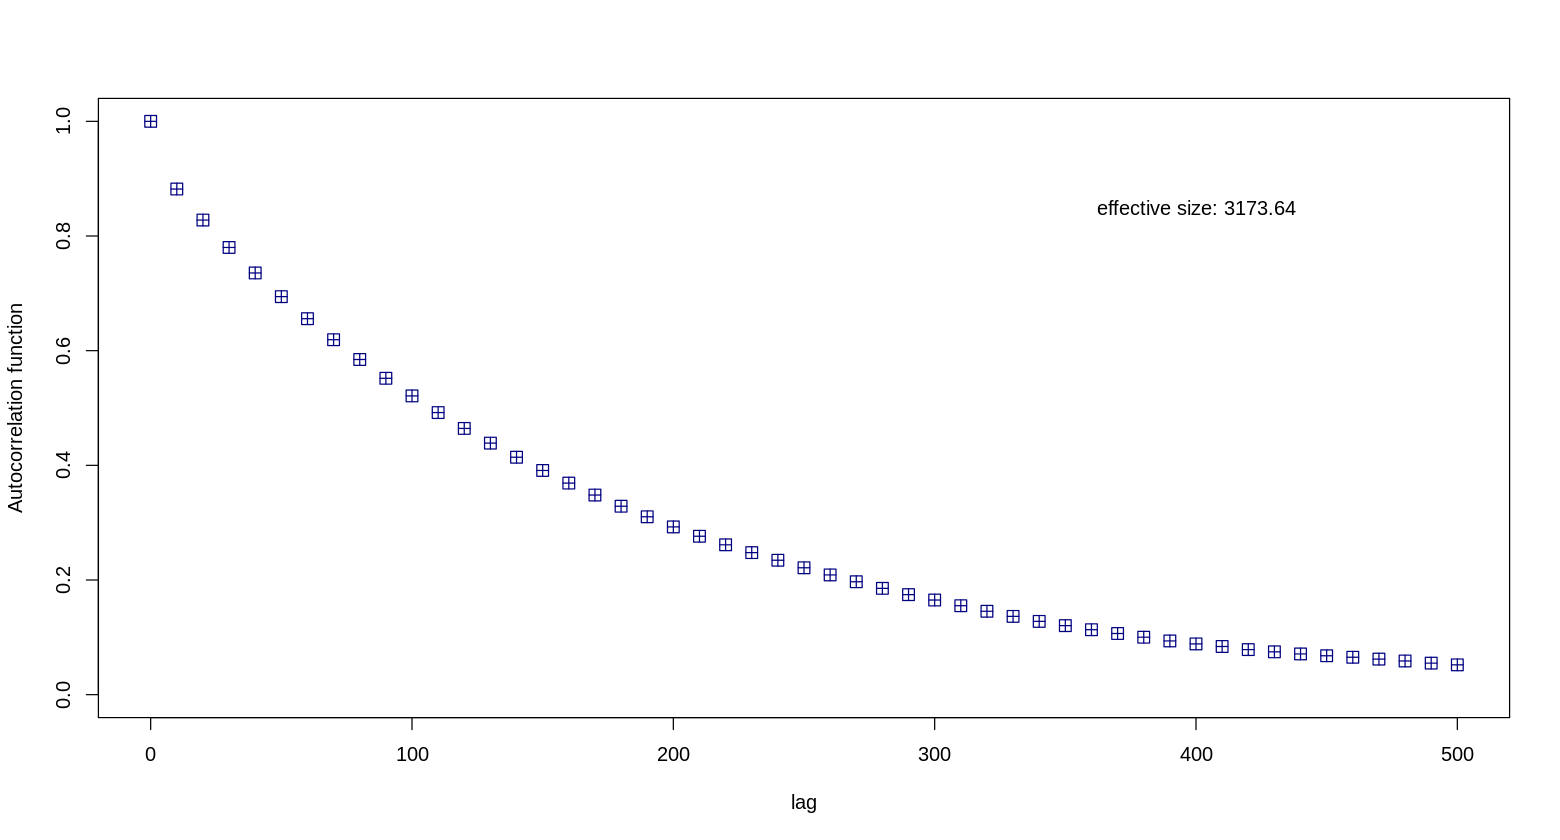

In [16]:
burn.in = c(0, 10, 10^3, 10^4)

for (i in 1:length(burn.in)) {
    chain = MC(n.samp, theta.init, sigma)
    chain = chain[-(1:burn.in[i]),]

    x = seq(-10, 10, length.out = 10^4)
    y = posterior(x)
    plot(x, y, type='l', lwd=2, col='firebrick3', xlab=expression(theta), ylab=expression(paste('g(',theta, '|x)', sep = '')),
         main = sprintf("Posterior Distribution with %.f burn-in", burn.in[i]))
    hist(chain[,2], breaks = seq(from = min(x), to = max(x), length.out = 100), freq = FALSE, col = 'navy', main = "Sampled Distribution", add = TRUE)
    legend("topleft", legend = c('Analytical', 'Sampled'), col=c('firebrick3', 'navy'), lwd = 2)

    c.chain = as.mcmc(chain[,2]) 
    my.lags = seq(0,500,10)
    y = autocorr(c.chain, lags=my.lags)
    plot(my.lags, y, ylim=c(0,1), pch=12, col='navy', xlab='lag', ylab='Autocorrelation function', cex=1.3)
    text(400,0.85, sprintf("effective size: %.2f", effectiveSize(c.chain)))   
}

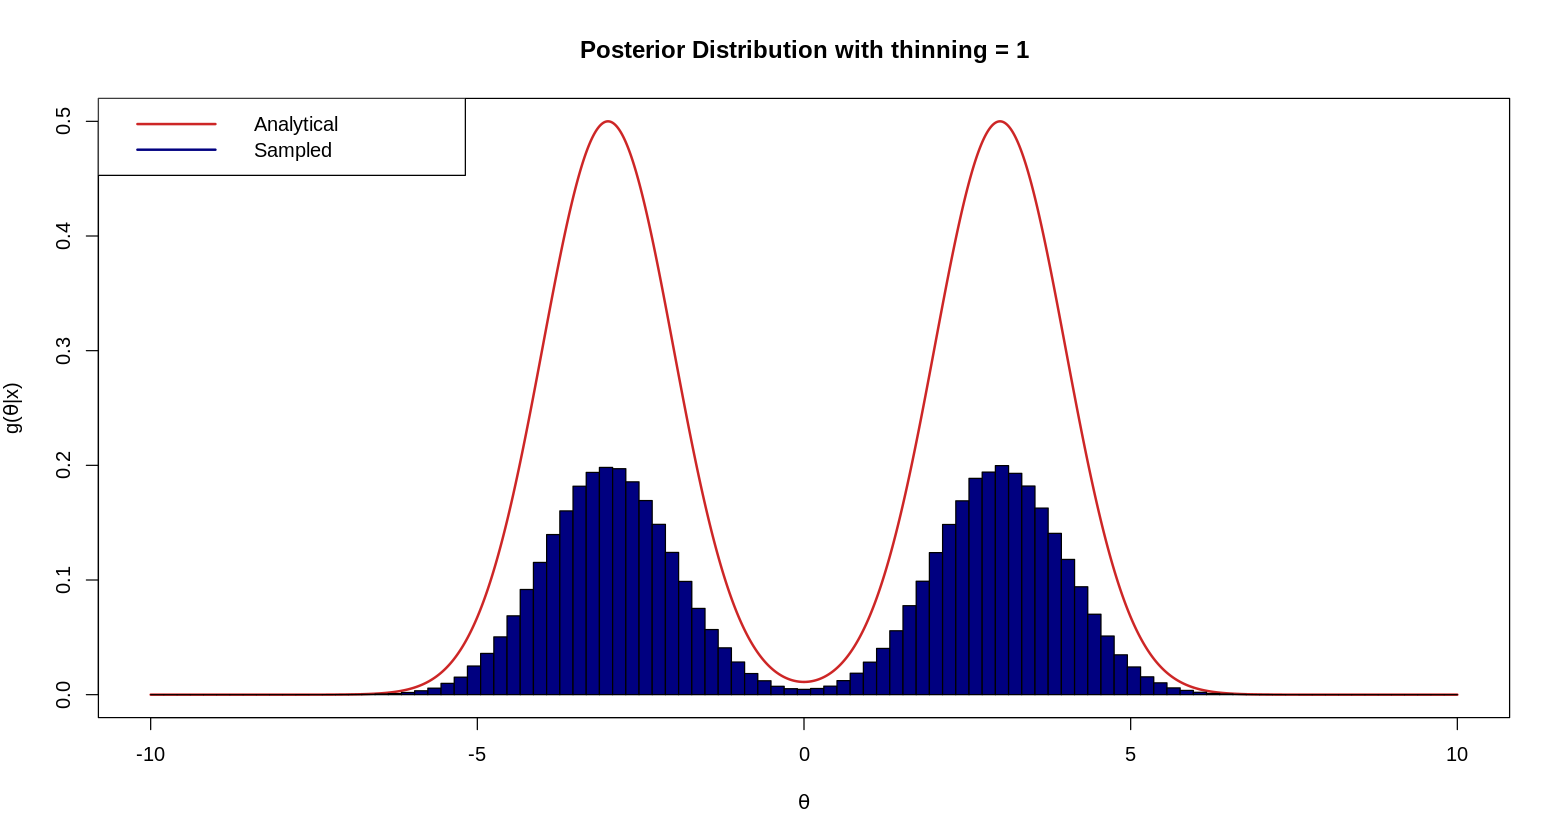

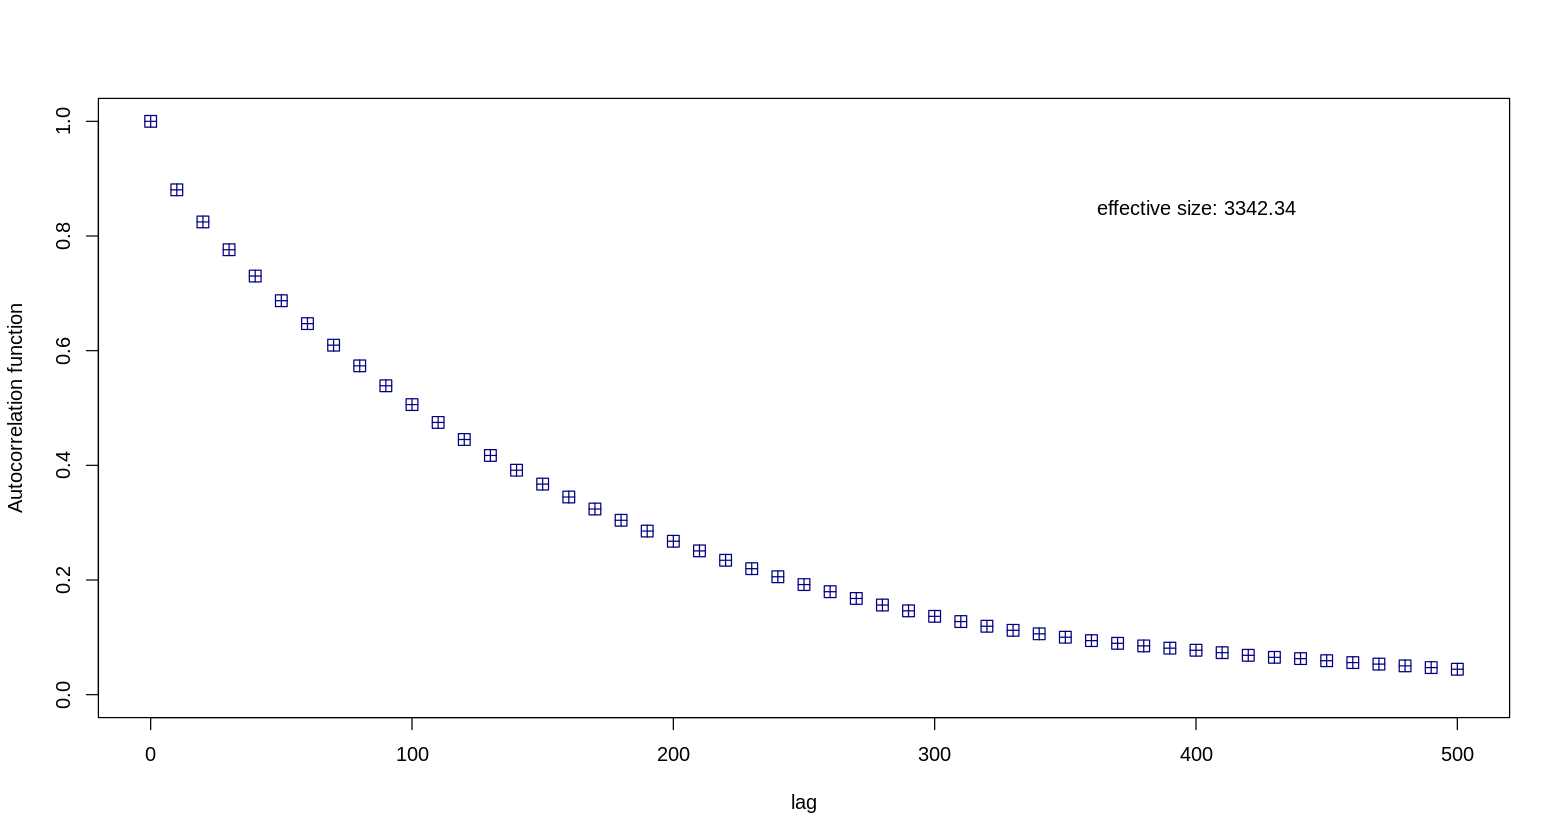

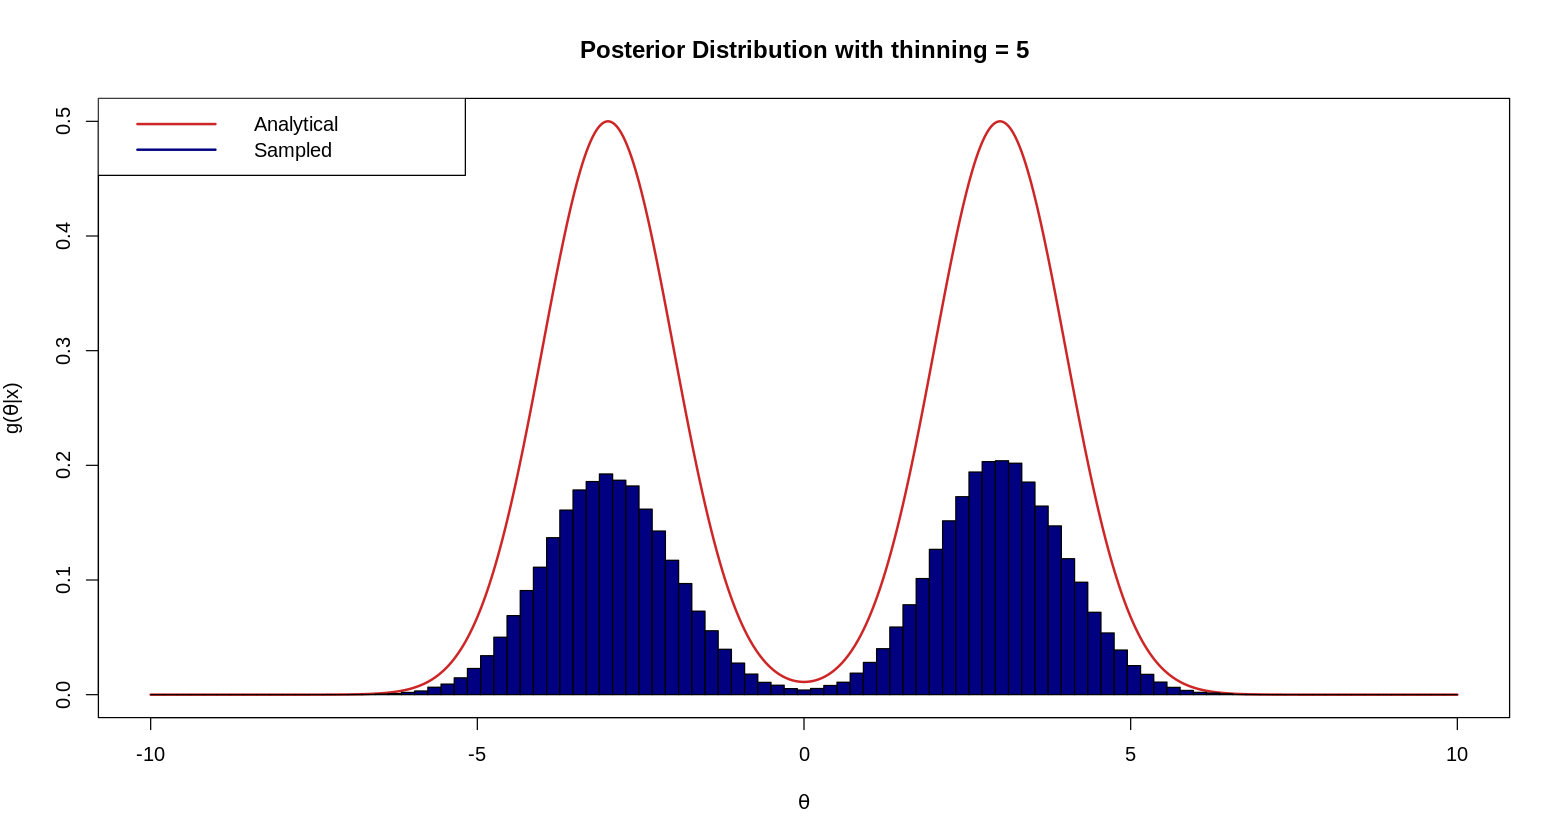

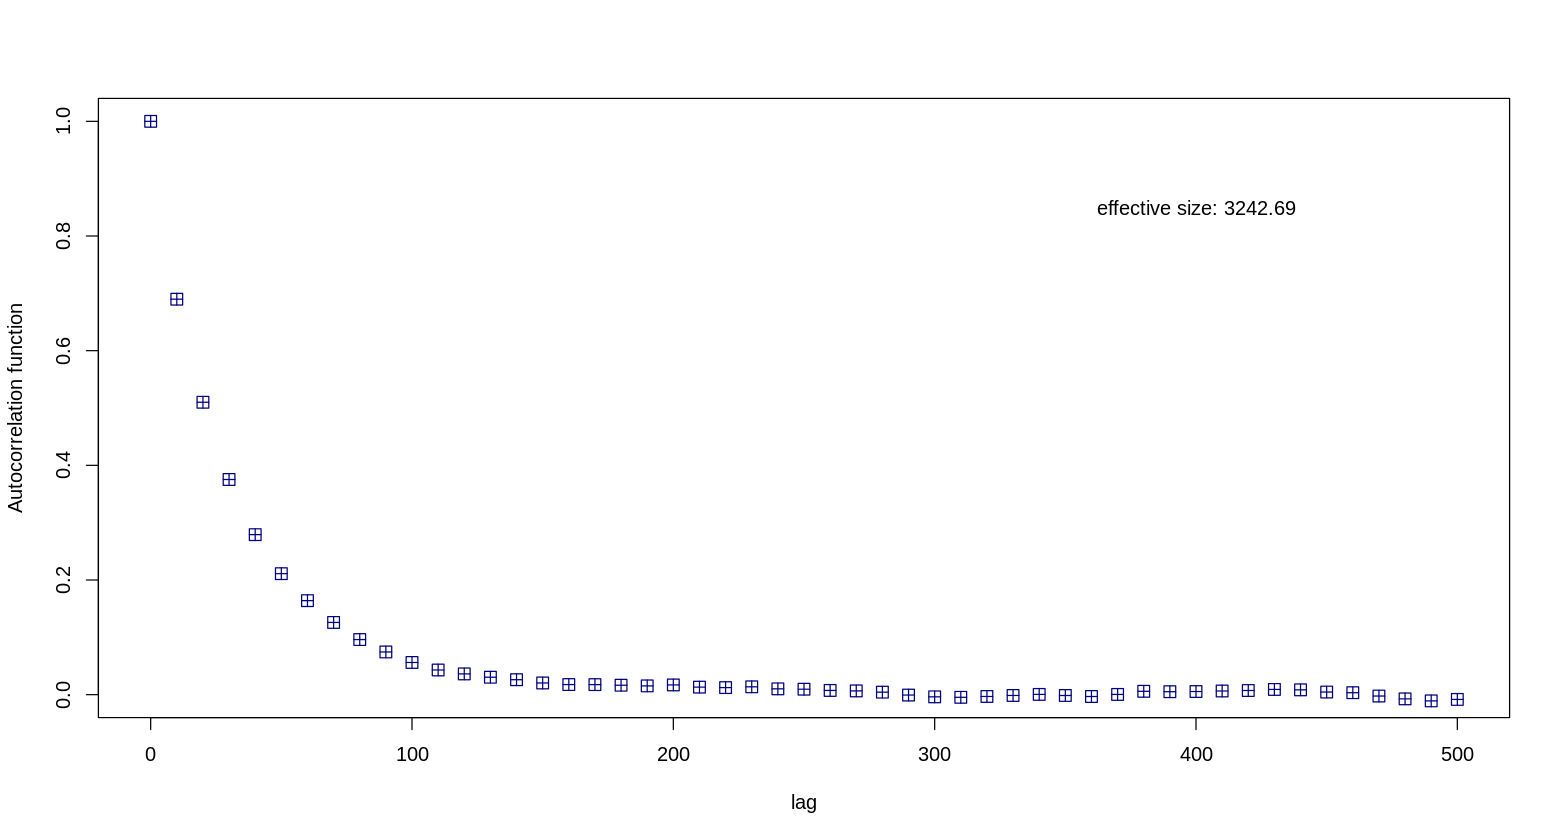

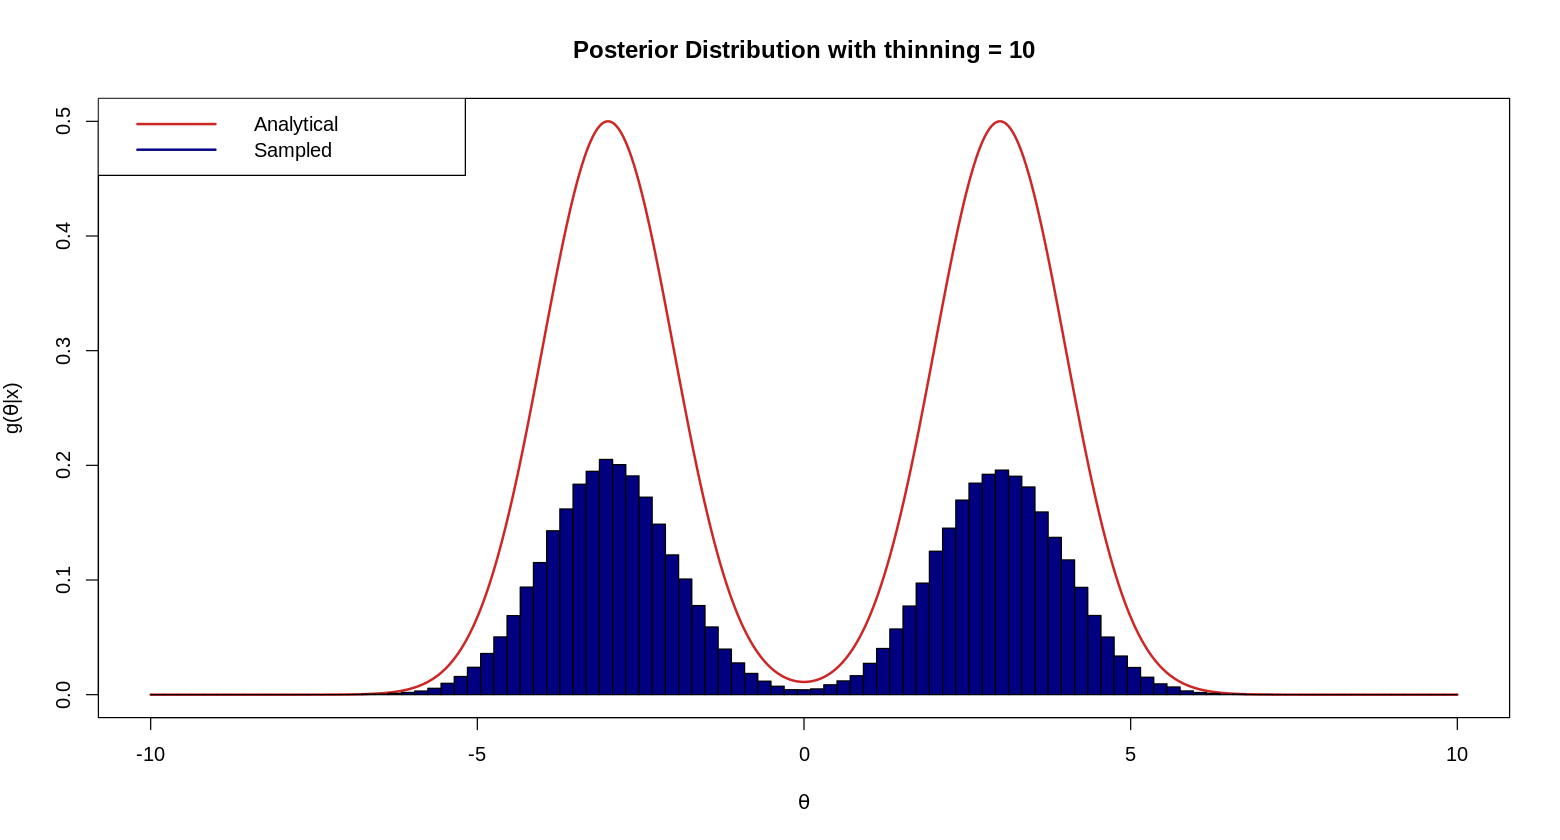

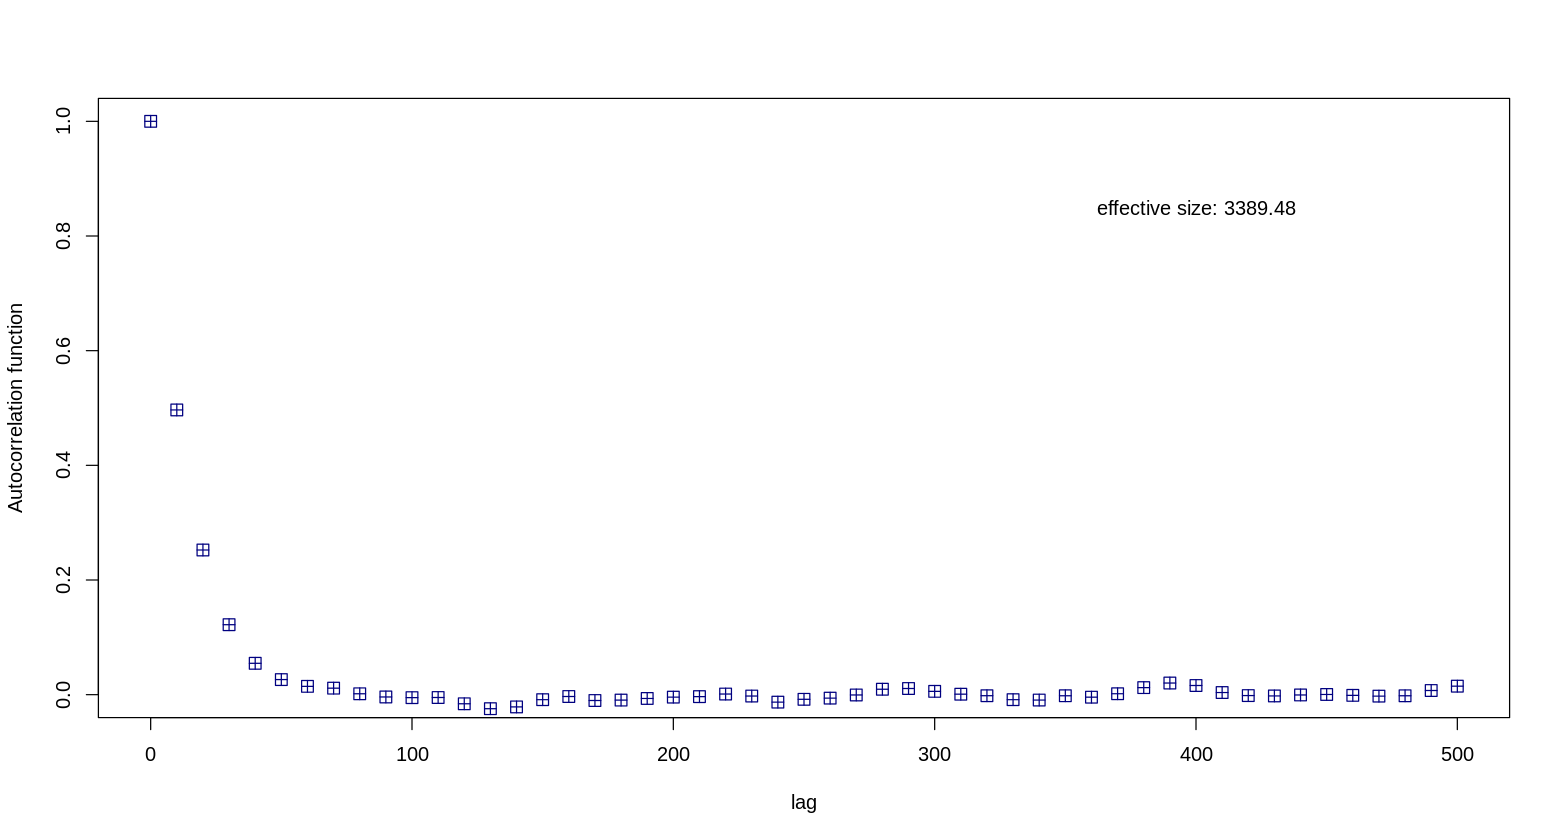

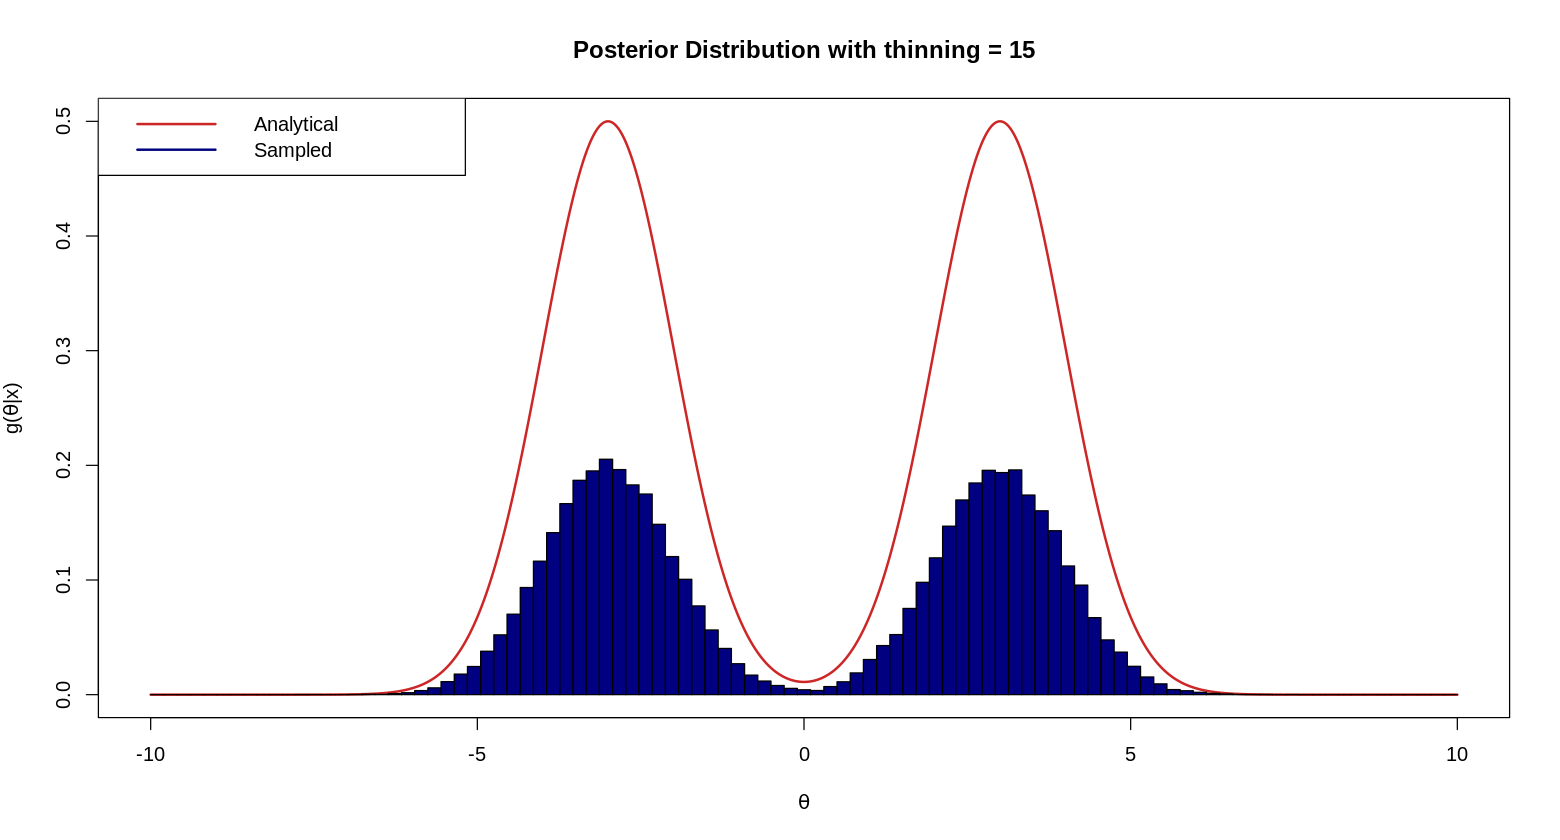

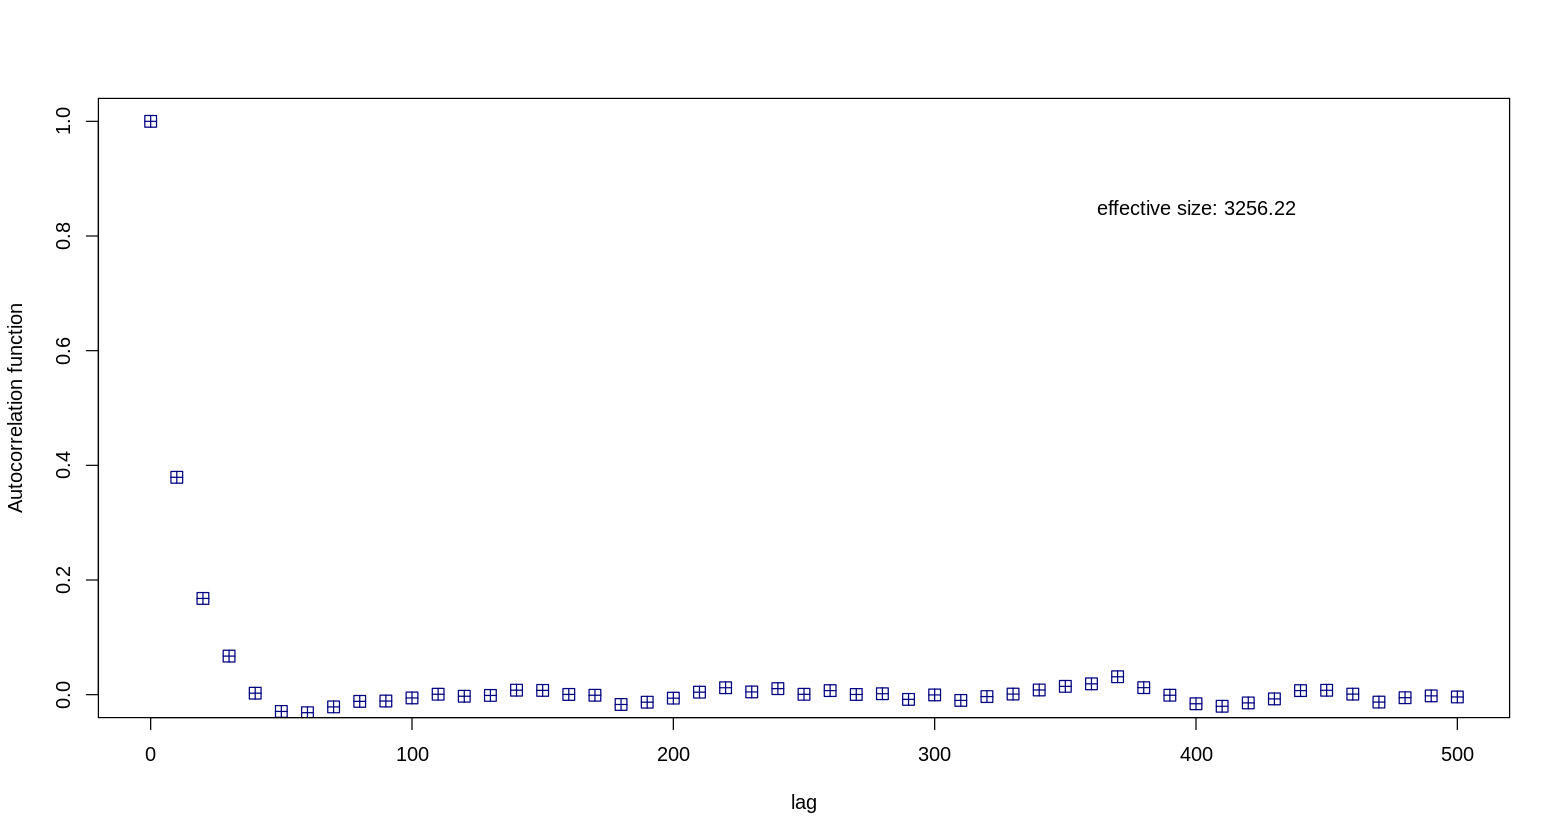

In [17]:
thin = c(1, 5, 10, 15)

for (i in 1:length(thin)) {
    chain = MC(n.samp, theta.init, sigma)
    chain = chain[seq(1, nrow(chain), by=thin[i]),]
    
    x = seq(-10, 10, length.out = 10^4)
    y = posterior(x)
    plot(x, y, type='l', lwd=2, col='firebrick3', xlab=expression(theta), ylab=expression(paste('g(',theta, '|x)', sep = '')),
         main = sprintf("Posterior Distribution with thinning = %.f", thin[i]))
    hist(chain[,2], breaks = seq(from = min(x), to = max(x), length.out = 100), freq = FALSE, col = 'navy', main = "Sampled Distribution", add = TRUE)
    legend("topleft", legend = c('Analytical', 'Sampled'), col=c('firebrick3', 'navy'), lwd = 2)

    c.chain = as.mcmc(chain[,2]) 
    my.lags = seq(0,500,10)
    y = autocorr(c.chain, lags=my.lags)
    plot(my.lags, y, ylim=c(0,1), pch=12, col='navy', xlab='lag', ylab='Autocorrelation function', cex=1.3)
    text(400,0.85, sprintf("effective size: %.2f", effectiveSize(c.chain)))   
}

## Esercizio 2

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:

Y = -7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326

X = 5, 6, 7, 8, 9, 10, 11, 12.

1) Perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS, assuming that:
    - data follow the model $Z[i] = a + b * X[i]$
    - the likelihood of the measured data follow a Gaussian likelihood distribution $Y[i]$ ~ $dnorm(Z[i], c)$
    - you can constrain the parameter a, b and c to the following intervals: a ∈ [1, 10], b ∈ [−1, 3] and c ∈ [0.034, 4]


 Run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.


In [12]:
X = c(5, 6, 7, 8, 9, 10, 11, 12)
Y = c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)

data = NULL
data$X = X
data$Y = Y

model = 'Rlab05_2.bugs'
jm = jags.model(model, data)
update(jm , 1000)

chain = coda.samples(jm , c('a', 'b', 'c'), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  1.48876 0.481624 4.816e-03      0.0110537
b -0.94895 0.048750 4.875e-04      0.0010272
c  0.04433 0.009705 9.705e-05      0.0002025

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
a  1.01391  1.14664  1.34089  1.67938  2.76589
b -0.99869 -0.98468 -0.96366 -0.92846 -0.81595
c  0.03427  0.03712  0.04155  0.04867  0.07008



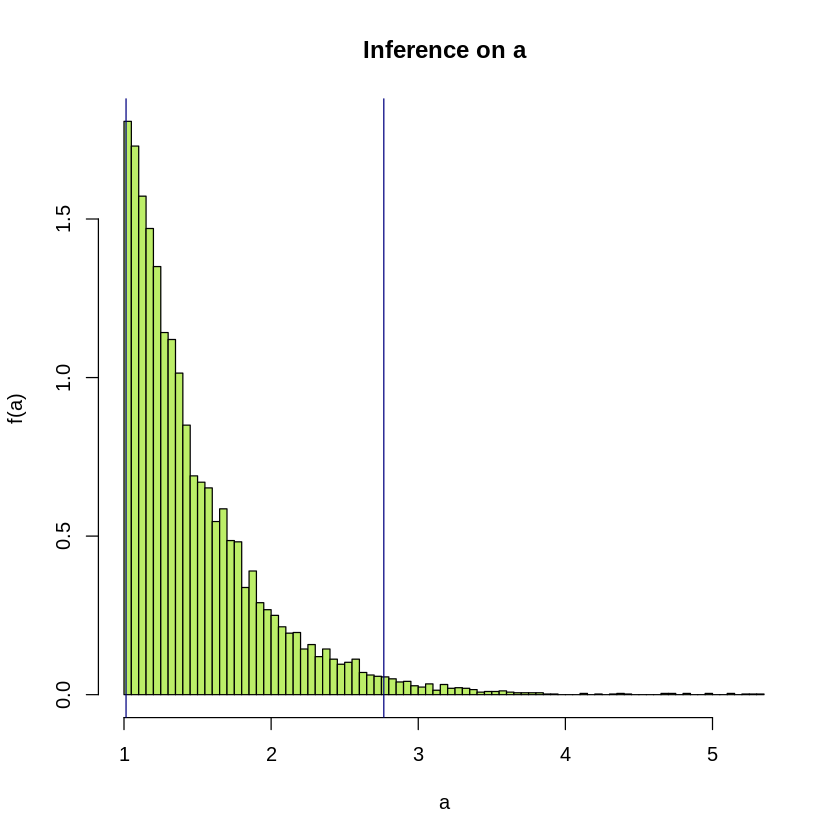

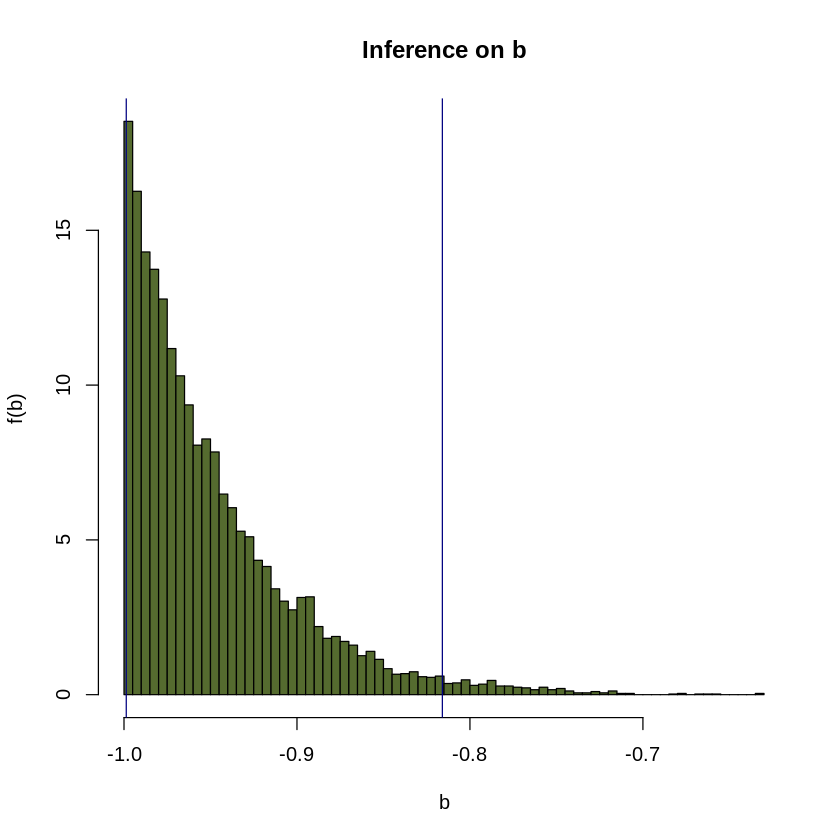

In [13]:
chain.df = as.data.frame(as.mcmc(chain))
quantiles = summary(chain)$quantiles 

hist(chain.df$a , nc=100, prob=TRUE , col='darkolivegreen2', xlab='a', ylab='f(a)', main='Inference on a')
abline(v=quantiles["a", "2.5%"], col='navy',lty=1)
abline(v=quantiles["a", "97.5%"], col='navy',lty=1)

hist(chain.df$b , nc=100, prob=TRUE , col='darkolivegreen', xlab='b', ylab='f(b)', main='Inference on b')
abline(v=quantiles["b", "2.5%"], col='navy',lty=1)
abline(v=quantiles["b", "97.5%"], col='navy',lty=1)

2) Using the obtained posterior distributions, compute the posterior distribution of $\sigma = \frac{1}{\sqrt{c}}$

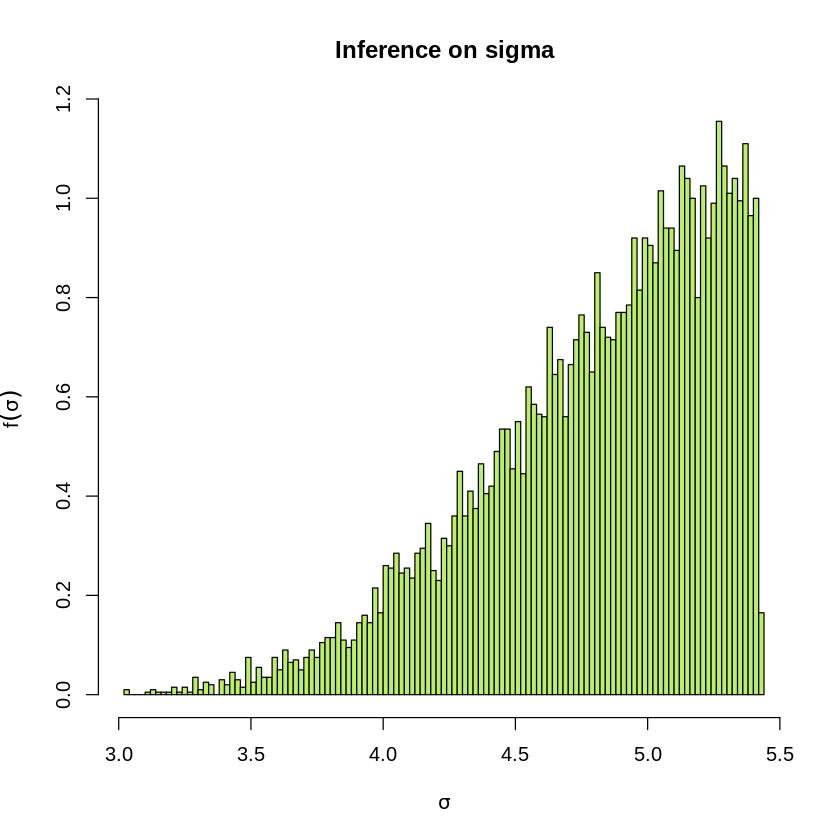

In [144]:
chain.sigma = 1 / sqrt(chain.df$c)
hist(chain.sigma , nc=100, prob=TRUE , col='darkolivegreen2', xlab=expression(sigma), ylab=expression(f(sigma)), main='Inference on sigma')

## Esercizio 3

Suppose we observe the following values: 

x = 2.06, 5.56, 7.93, 6.56, 205

and assume that the data come from a gaussian distribution with unknown mean m and variance s$^2$.

1) Build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance:

Assume uniform prior distributions for the parameters, m ~ dunif(-10, 10) and s ~ dunif(0,50),  compute also the posterior distribution for m/s:

In [20]:
data = NULL
data$X = c(2.06, 5.56, 7.93, 6.56, 205)

model = "Rlab05_3.bugs"

jm = jags.model(model, data)
update(jm , 1000)
chain = coda.samples(jm, c("mu", "sigma", "ms"), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 16

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean     SD Naive SE Time-series SE
ms     0.06711 0.1099 0.001099       0.001785
mu     3.14621 5.1659 0.051659       0.083634
sigma 47.24269 2.3523 0.023523       0.045117

2. Quantiles for each variable:

         2.5%       25%      50%    75%   97.5%
ms    -0.1805 -0.006764  0.09032  0.158  0.2108
mu    -8.5533 -0.325907  4.25177  7.478  9.7733
sigma 41.1329 46.042094 47.86726 49.064 49.9211



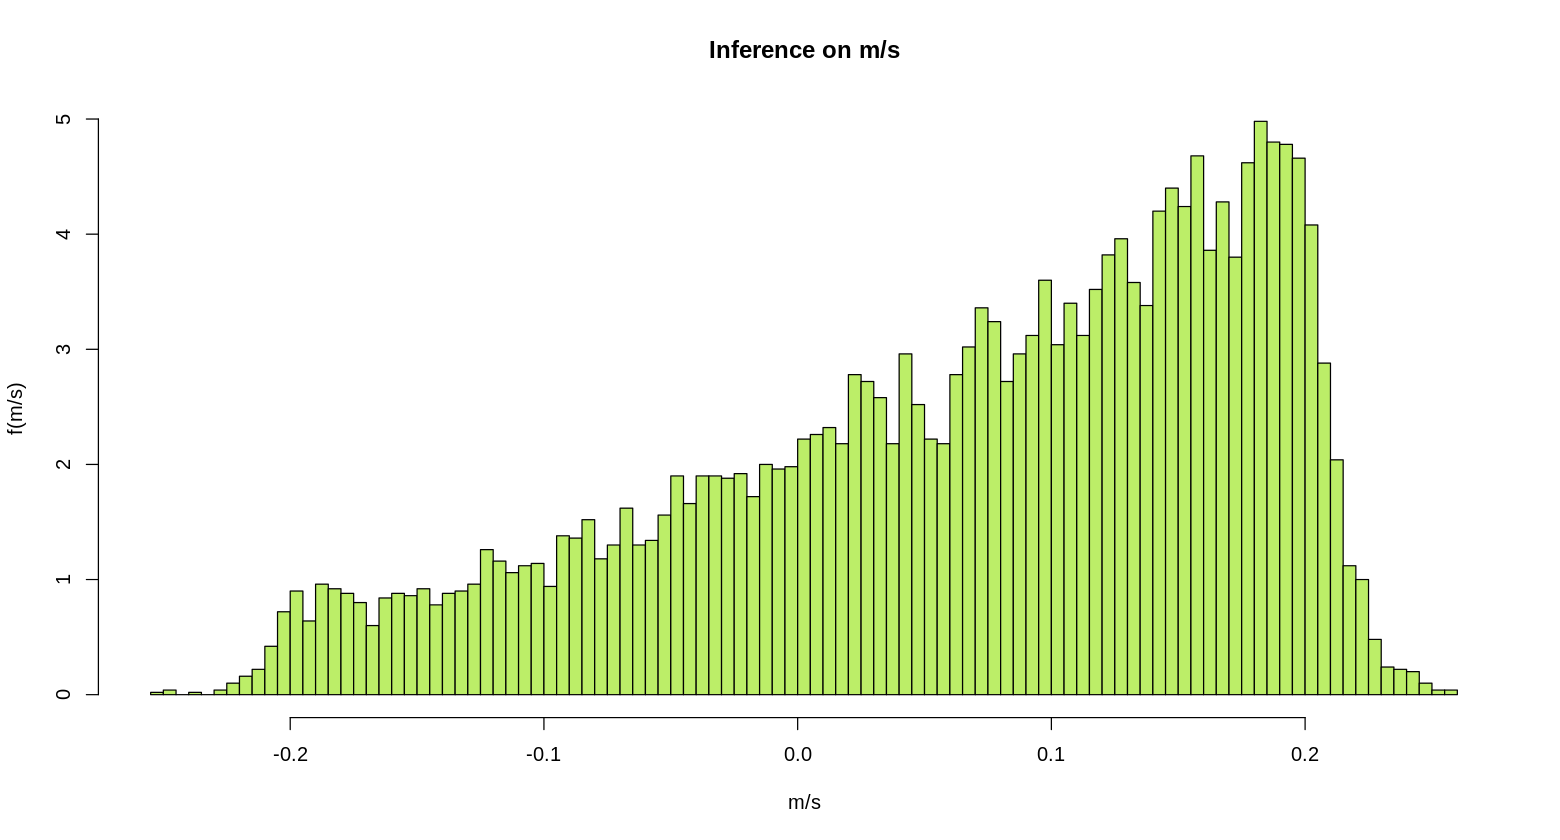

In [22]:
chain.df = as.data.frame(as.mcmc(chain))
hist(chain.df$ms , nc=100, prob=TRUE , col='darkolivegreen2', xlab='m/s', ylab='f(m/s)', main='Inference on m/s')

## Exercise 4

The data set that Edwin Hubble used to show that galaxies are moving either away or towards us are given in the following table:
  $$
  \begin{array}{c|cccc}
  D & 0.032 & 0.034 & 0.214 & 0.263 & 0.275 \\
  V & 170 & 290 & -130 & -70 & -185 \\
  \hline
  D & 0.275 & 0.45 & 0.5 & 0.5 & 0.63 \\
  V & -220 & 200 & 290 & 270 & 200 \\
  \hline
  D & 0.8 & 0.9 & 0.9 & 0.9 & 0.9 \\
  V & 920 & 450 & 500 & 500 & 960 \\
  \hline
  D & 2 & 2 & 2 & 2 \\
  V & 500 & 850 & 800 & 1090 \\
  \end{array}
  $$
  
Using this data set, define a JAGS model to fit data with the following:
    $$
    V[i] \sim \text{dnorm}(b \cdot D[i], c)
    $$
Where $V$ represents the velocity in units of km/s, $D$ is the observed distance (in units of parsec), and $b$ and $c$ are two parameters of the model. Assume whatever prior distribution you think is appropriate.

Plot the evolution of the chains, the posterior distribution of the parameters, and the 95% credibility interval.

In [14]:
D = c(0.032, 0.034, 0.214, 0.263, 0.275, 0.275, 0.45, 0.5, 0.5, 0.63, 0.8, 0.9, 0.9, 0.9, 0.9, 2, 2, 2, 2)
V = c(170, 290, -130, -70, -185, -220, 200, 290, 270, 200, 920, 450, 500, 500, 960, 500, 850, 800, 1090)

data = NULL
data$D = D
data$V = V

model = 'Rlab05_4.bugs'
jm = jags.model(model, data)
update(jm , 1000)

chain = coda.samples(jm , c('b', 'c'), n.iter=10000)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 61

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
b 4.582e+02 6.240e+01 6.240e-01      8.061e-01
c 1.346e-05 4.576e-06 4.576e-08      6.229e-08

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
b 3.365e+02 4.168e+02 4.584e+02 4.997e+02 5.813e+02
c 6.017e-06 1.020e-05 1.291e-05 1.613e-05 2.403e-05



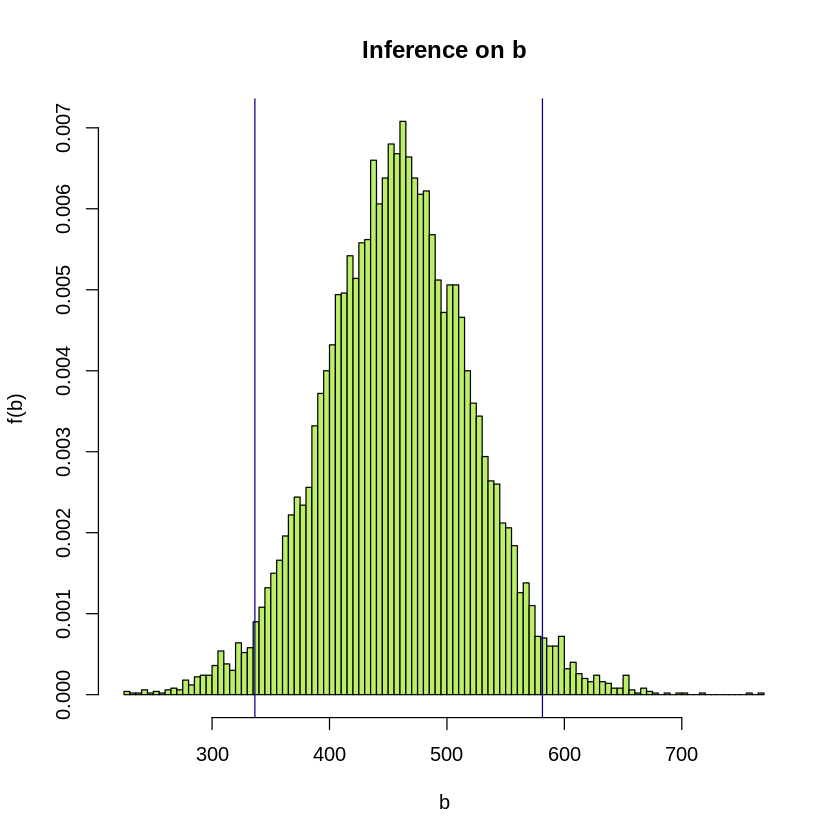

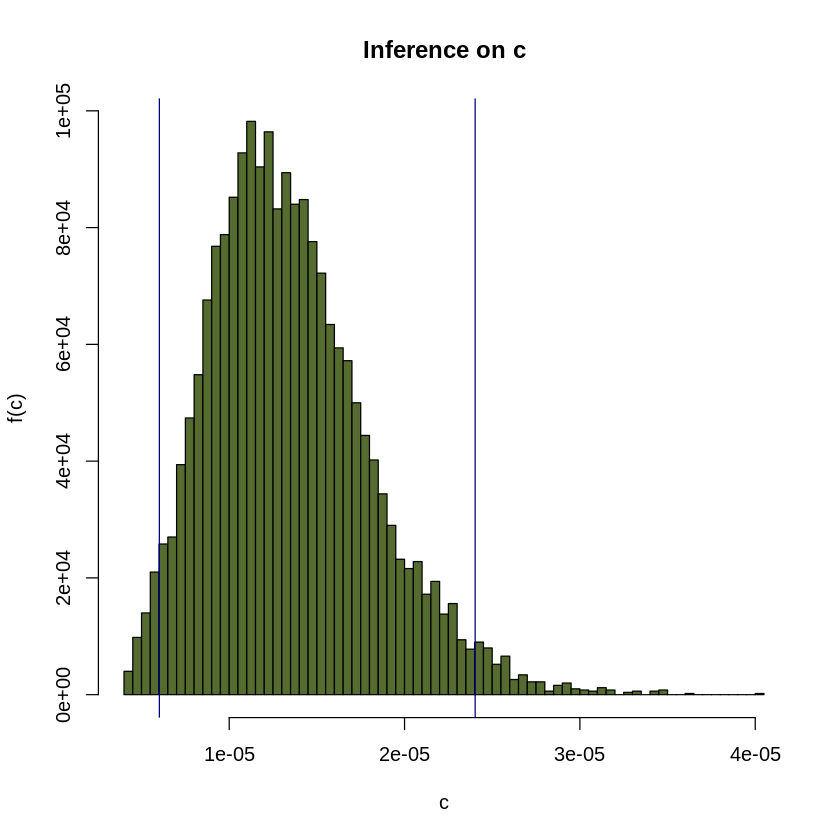

In [15]:
chain.df = as.data.frame(as.mcmc(chain))
quantiles = summary(chain)$quantiles

hist(chain.df$b , nc=100, prob=TRUE , col='darkolivegreen2', xlab='b', ylab='f(b)', main='Inference on b')
abline(v=quantiles["b", "2.5%"], col='navy',lty=1)
abline(v=quantiles["b", "97.5%"], col='navy',lty=1)

hist(chain.df$c , nc=100, prob=TRUE , col='darkolivegreen', xlab='c', ylab='f(c)', main='Inference on c')
abline(v=quantiles["c", "2.5%"], col='navy',lty=1)
abline(v=quantiles["c", "97.5%"], col='navy',lty=1)